# Setup

In [86]:
import os

import random
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from graph_loader import load_graphs

from part import Part
from typing import Set

import torch.optim as optim

from evaluation import MyPredictionModel


import torch
import torch.nn as nn
from graph import Graph

In [87]:
# MPS for Metal acceleration for Mac
# device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu")
# device = torch.device("cpu")
SEED = 0
random.seed(SEED)
# setgrad = lambda g, *ms: [setattr(p,'requires_grad', g) for m in ms for p in m.parameters() ]  

# Hyperparameter:
input_dim = 4542        # Fest
hidden_dim = 1024       # 128 / 1024 / 2048 / 4542   -> Input = obere schranke
output_dim = 2271       # Fest
learning_rate = 0.0005  # 0.01 / 0.001 / 0.0005
num_epochs = 50         # Fest
batch_size = 128          # 16 / 32 / 64

# 1. GraphDataSet

In [88]:
from sklearn.model_selection import train_test_split


class GraphDataset(Dataset):
    def __init__(self, file_path: str, train=False, validation=False, test=False, seed=42):
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Dataset file not found at {file_path}")

        self.graphs = load_graphs(file_path)

        if sum([train, validation, test]) != 1:
            raise ValueError("Exactly one of 'train', 'validation', or 'test' must be True.")


        # Create global mapping for unique parts
        self.family_part_dict = {}


        unique_parts = set()
        for graph in self.graphs:
            parts = graph.get_parts()
            for part in parts:
                unique_parts.add(int(part.get_part_id()))
                self.family_part_dict[int(part.get_part_id())] = int(part.get_family_id())

        # unique parts and mapping across all graphs (not just within a certain split)
        unique_parts = sorted(list(unique_parts))
        self.total_global_part_to_idx = {part: idx for idx, part in enumerate(unique_parts)} # mapping part_id to index
        self.idx_to_part_id = {idx: part for part, idx in self.total_global_part_to_idx.items()}  # Reverse mapping

        self.total_num_unique_parts = max(unique_parts)+1
        # self.total_num_unique_parts = len(unique_parts)

        # Split: 70% training, 15% validation, 15% test
        train_graphs, test_graphs = train_test_split(self.graphs, test_size=0.3, random_state=seed)
        validation_graphs, test_graphs = train_test_split(test_graphs, test_size=0.5, random_state=seed)

        # Create Train and Test Split:
        if train:
            self.graphs = train_graphs
        elif validation:
            self.graphs = validation_graphs
        elif test:
            self.graphs = test_graphs

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        '''
        Returns the parts and the corresponding graph at the given index.
        '''
        return self.graphs[idx].get_parts(), self.graphs[idx]

    def encode_features(self, parts):
        """
            1. Sortieren alle parts in graphen nach partID
            2. Erstellen Frequency Encoding für part
            3. Erstellen one Hot Encoding für parts
            4. Combines Encodings in einen gestackten vektor
        """

        # sort parts by part_id and convert to list
        parts = sorted(parts, key=lambda part: int(part.get_part_id()))
        parts = list(parts)
        
        combined_tensors = []
        # frequency encoding
        part_frequency_tensor = self.frequency_encoding(parts)              # Für alle Parts einmal pro Graph
        for part in parts:
            # one hot encoding
            one_hot_encoded = self.one_hot_encoding(part)                   # Pro part meheree male pro Graph
            combined_tensor = torch.cat((part_frequency_tensor, one_hot_encoded), dim=0)
            combined_tensors.append(combined_tensor)
        # transform list of tensors to tensor
        combined_tensors = torch.stack(combined_tensors)
        return combined_tensors

    # TODO Werte checken - wird passen
    def frequency_encoding(self, parts):
        """ 
        Frequency encoding of parts in a graph including the mapping to the global part index.
        """
        part_frequency_tensor = np.zeros(self.total_num_unique_parts, dtype=np.int32)
        for part in parts:
            part_id = int(part.get_part_id())
            part_frequency_tensor[part_id] += 1

            # mapped_id = self.total_global_part_to_idx[part_id]
            # part_frequency_tensor[mapped_id] += 1
        # cast to tensor
        part_frequency_tensor = torch.tensor(part_frequency_tensor, dtype=torch.float32)
        return part_frequency_tensor

    # TODO Werte checken - wird passen
    def one_hot_encoding(self, part):
        """
        One-hot encoding of part including the mapping to the global part index.
        """
        one_hot_encoded = np.zeros(self.total_num_unique_parts, dtype=np.int32)
        part_id = int(part.get_part_id())
        one_hot_encoded[part_id] = 1
        # mapped_id = self.total_global_part_to_idx[part_id]
        # one_hot_encoded[mapped_id] = 1
        # cast to tensor
        one_hot_encoded = torch.tensor(one_hot_encoded, dtype=torch.float32)
        return one_hot_encoded

    
    def graph_to_neighbour_matrix(self, graph):
        """
        This will not create the adjacency matrix, but rather for each node a tensor with the neighbours. 
        These tensors are then stacked to create the neighbour matrix.




        Erstellt für Graphn die gesamte Adjazenzmatrix: oben / x: Source, links / y: target

        Genauso viele Spalten wie Parts in graphen (e.g. für gleiche PartIDs mehere Spalten) und insg. Reihen pro spalte für 2000 parts

            58, 58, 58, 58 1621 source
            1   2   3   4  5
        1
        2
        3               One-hot encoded
        ...
        target


        """
        neighbours = graph.get_edges()
        # sort nodes by part_id -> because our features were also sorted according to part_id
        nodes = sorted(graph.get_nodes(), key=lambda node: int(node.get_part().get_part_id()))

        neighbour_matrix = []

        for node in nodes:
            
            neighbour_tensor = torch.zeros(self.total_num_unique_parts, dtype=torch.float32)
            # find the neighbours of each node
            for current_neighbour in neighbours[node]:
                neighbour_id = int(current_neighbour.get_part().get_part_id())
                neighbour_tensor[neighbour_id] = 1
                # mapped_id = self.total_global_part_to_idx[neighbour_id]
                # neighbour_tensor[mapped_id] = 1

            neighbour_matrix.append(neighbour_tensor)
        
        # transform list of tensors to tensor
        neighbour_matrix = torch.stack(neighbour_matrix)
        return neighbour_matrix


# 2. PartDataSet

In [89]:
class PartDataset(Dataset):
    def __init__(self, graph_dataset):
        """
        Initialisiert das PartDataset basierend auf dem bestehenden GraphDataset.
        Erstellt ein Datenset, welches jeweils als feature die Kombination aus Frequency Encoding und One-Hot Encoding enthält und als label die Nachbarn jedes Knotens.
        :param graph_dataset: Instanz von GraphDataset.
        """
        self.features = []
        self.labels = []

        """
            Wir holen uns parts aus graphen, wir sortieren die PartIDs
            Erzeugen wir frequency (für graphen) und one hot (für einzelne Parts) vektoren
        """

        for parts, graph in graph_dataset:

            # Feature 1: Frequency encoded graph using part_ids
            part_ids_graph = graph.get_parts()
            part_ids_graph = [int(part.get_part_id()) for part in part_ids_graph]
            feature_graph = torch.zeros(graph_dataset.total_num_unique_parts, dtype=torch.float)
            for part_id in part_ids_graph:
                feature_graph[part_id] += 1

            # Feature 2: One Hot encoding per Part + neighboring matrix kombiniert aufgebaut
            edges = graph.get_edges()
            for source_node, target_nodes in edges.items():
                source_id = int(source_node.get_part().get_part_id())

                # One-hot encode the source_id with pytorch tensors
                feature_source_id = torch.zeros(graph_dataset.total_num_unique_parts, dtype=torch.float)
                feature_source_id[source_id] = 1

                target = torch.zeros(graph_dataset.total_num_unique_parts, dtype=torch.float)
                for target_node in target_nodes:
                    target_id = int(target_node.get_part().get_part_id())
                    target[target_id] = 1

                self.labels.append(target)
                self.features.append(torch.cat([feature_graph, feature_source_id]))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        """
        Gibt die Features und das Label für den angegebenen Index zurück.
        """
        return self.features[idx], self.labels[idx]


# 3. Setup DataSets

In [90]:
training_set = GraphDataset("data/graphs.dat", train = True, seed=SEED)
validation_set = GraphDataset("data/graphs.dat", validation = True, seed=SEED)
testing_set = GraphDataset("data/graphs.dat", test = True, seed=SEED)

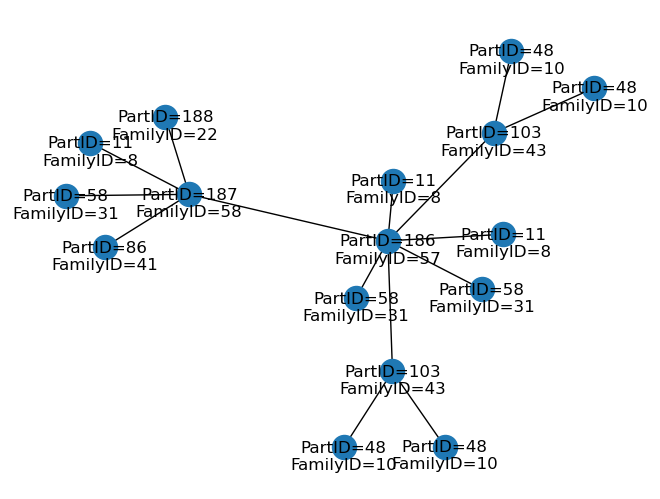

Features: ---------------------
4542
186     1.0
Labels / Edges: ---------------
11    1.0
58    1.0
103    1.0
187    1.0


In [71]:
# Erstelle ein PartDataset aus deinem GraphDataset
train_part_dataset = PartDataset(training_set)      # --> Länge 59275 alle parts in allen Graphen (Alle graph - PArtID combis)
val_part_dataset = PartDataset(validation_set)

training_set.graphs[0].draw()
example_column = 0      # Max 59275

print("Features: ---------------------")
print(len(train_part_dataset.features[0]))
for i, part in enumerate(train_part_dataset.features[example_column]):
    if i > output_dim and train_part_dataset.features[example_column][i].item() > 0:
        print(i - output_dim, "   ", train_part_dataset.features[example_column][i].item())

print("Labels / Edges: ---------------")
for i, edge in enumerate(train_part_dataset.labels[example_column]):
    if train_part_dataset.labels[example_column][i].item() > 0:
        print(i, "  ", train_part_dataset.labels[example_column][i].item())


In [72]:
# Train part Dataset:
print(len(train_part_dataset.features))
print(len(train_part_dataset.features[0]))
print(train_part_dataset.features[0])
print(train_part_dataset.features[0][3].item())

print(len(train_part_dataset.labels))
print(len(train_part_dataset.labels[0]))
print(train_part_dataset.labels[0])
print(train_part_dataset.labels[0][3].item())

59757
4542
tensor([0., 0., 0.,  ..., 0., 0., 0.])
0.0
59757
2271
tensor([0., 0., 0.,  ..., 0., 0., 0.])
0.0


In [73]:
# Print all Edges in Graph 0:
for j in range(0,6):
    for i, element in enumerate(train_part_dataset[j][0]):
        if i >= (output_dim-1) and element >= 1:
            print(f"source -> part_id {i - output_dim}")

    # neighbours
    for i, element in enumerate(train_part_dataset[j][1]):
        if element > 0:
            print(f"target -> part_id {i}")
    
    print(50*"-")

source -> part_id 186
target -> part_id 11
target -> part_id 58
target -> part_id 103
target -> part_id 187
--------------------------------------------------
source -> part_id 187
target -> part_id 11
target -> part_id 58
target -> part_id 86
target -> part_id 186
target -> part_id 188
--------------------------------------------------
source -> part_id 103
target -> part_id 48
target -> part_id 186
--------------------------------------------------
source -> part_id 103
target -> part_id 48
target -> part_id 186
--------------------------------------------------
source -> part_id 11
target -> part_id 186
--------------------------------------------------
source -> part_id 58
target -> part_id 186
--------------------------------------------------


# Neighbour Prediction

Für jeden Part die wahrscheinlichsten Nachbarn vorhersagen

## Feedforward Neural Network

In [9]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self._init_weights()

    def _init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
        

    def train_ffnn(self, train_dataset, val_dataset, num_epochs, batch_size, learning_rate, device):

        # Move model to device
        self.to(device)

        # Initialize criterion and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        # Prepare DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        # Document Losses and Accuracies
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):

            # Training Phase:
            self.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for batch_inputs, batch_labels in train_loader:
                batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

                optimizer.zero_grad()
                outputs = self(batch_inputs)  # Forward pass
                loss = criterion(outputs, batch_labels)  # Compute loss

                # Backwards Pass and Update weights:
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Calculate training accuracy
                predictions = (outputs >= 0.5).float()  # Round probabilities to 0 or 1
                correct_train += (predictions == batch_labels).sum().item()  # Count correct predictions
                total_train += batch_labels.numel()  # Total number of labels

            avg_train_loss = running_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            train_accuracy = correct_train / total_train  # Accuracy as ratio
            train_accuracies.append(train_accuracy)

            # Validation Phase:
            self.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_outputs = self(val_inputs)  # Forward pass
                    val_loss = criterion(val_outputs, val_targets)  # Compute loss
                    running_val_loss += val_loss.item()

                    # Calculate validation accuracy
                    val_predictions = (val_outputs >= 0.5).float()  # Round probabilities to 0 or 1
                    correct_val += (val_predictions == val_targets).sum().item()  # Count correct predictions
                    total_val += val_targets.numel()  # Total number of labels

            avg_val_loss = running_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            val_accuracy = correct_val / total_val  # Accuracy as ratio
            val_accuracies.append(val_accuracy)

            # Print epoch summary
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Train Acc: {train_accuracy:.4f}, "
                f"Val Loss: {avg_val_loss:.6f}, Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies



    """
    def train_ffnn(self, train_dataset, val_dataset, num_epochs, batch_size, learning_rate, device):

        # Move model to device
        self.to(device)

        # Initialize criterion and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        # Prepare DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Document Losses:
        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):

            # Training Phase:
            self.train()
            running_loss = 0.0

            for batch_inputs, batch_labels in train_loader:
                batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

                optimizer.zero_grad()
                outputs = self(batch_inputs)  # Forward pass
                loss = criterion(outputs, batch_labels)  # Compute loss

                # Backwards Pass and Update weights:
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_train_loss = running_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation Phase:
            self.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_outputs = self(val_inputs)  # Forward pass
                    val_loss = criterion(val_outputs, val_targets)  # Compute loss
                    running_val_loss += val_loss.item()

            avg_val_loss = running_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Print epoch summary
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

        return train_losses, val_losses
"""

In [ ]:
import csv 
import os


# Initialize the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ffnn = FFNN(input_dim, hidden_dim, output_dim).to(device)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = ffnn.train_ffnn(
    train_dataset=train_part_dataset,
    val_dataset=val_part_dataset,
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    device=device
)


# Prepare results for saving
results = []
for epoch in range(len(train_losses)):
    results.append({
        "epoch": epoch + 1,
        "train_loss": train_losses[epoch],
        "train_accuracy": train_accuracies[epoch],
        "val_loss": val_losses[epoch],
        "val_accuracy": val_accuracies[epoch]
    })

# Create the folder if it doesn't exist
output_folder = "hyperparameter_tuning"
os.makedirs(output_folder, exist_ok=True)

# Save results to CSV
output_file = os.path.join(output_folder, f"{hidden_dim}-{batch_size}-{learning_rate}-training_results.csv")
with open(output_file, "w", newline="") as csvfile:
    fieldnames = ["epoch", "train_loss", "train_accuracy", "val_loss", "val_accuracy"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerows(results)

print("Training results saved to training_results.csv")



# Save the trained model
file_path = "ffnn_model.pth"
torch.save(ffnn.state_dict(), file_path)
print(f"Model saved to {file_path}")

## Evaluate FNN Performance

In [ ]:
for i, el in enumerate(train_part_dataset[0][0]):
    if el >= 1:
        print(i, el)

output = ffnn(train_part_dataset.features[2389].to(device))
target = train_part_dataset.labels[2389]

probs = ffnn(train_part_dataset[6][0].to(device))
probs.max()

print("-----------")
for i in range(0, output_dim):
    if target[i].item() > 0:
        print(i, target[i].item(), "  ---  ", output[i].item())
    if output[i].item() > 0.5:
        print(i, target[i].item(), "  ---  ", output[i].item())

## Visualize

## Jonas Graph Prediction

Nachdem wir nun eine Möglichkeit haben, pro Knoten/Part die Wahrscheinlichkeit für den/die direkten Nachbarn zu berechnen, müssen wir daraus nur noch den Gaphen zusammenbauen

In [12]:
class GraphPrediction(MyPredictionModel):
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset
        self.total_global_part_to_idx = dataset.total_global_part_to_idx  # PartID -> Index mapping
    
    def predict_graph(self, parts: Set[Part]) -> Graph:
        '''We get a set of parts and build a fully connected graph out of this. The edges are given a weight obtained from the model.
        Then we want to minimize the fully connected graph to a graph with the fewest edges possible. 
        We do this by only keeping the edges with the highest weights. This is the same as keeping the minimal 1-weight edges.
        This can be done by getting the minimal spanning tree of the graph. 
        '''

        # ich sortiere die Parts nach ihrer ID
        parts = sorted(parts, key=lambda part: int(part.get_part_id()))
        parts = list(parts)

        # ich encode die parts -> 
        part_frequency_tensor = self.dataset.frequency_encoding(parts)
        predicted_neighbours = []
        for part in parts:
            one_hot_encoded = self.dataset.one_hot_encoding(part)
            combined_tensor = torch.cat((part_frequency_tensor, one_hot_encoded), dim=0)
            # ich setze die parts in mein Modell ein und erhalte dann eine Matrix mit den Wahrscheinlichkeiten der Kanten
            neighbour_prediction = ffnn(combined_tensor.to(device))
            # print(f"neighbour_prediction max: {neighbour_prediction.max()}")
            predicted_neighbours.append(neighbour_prediction)
        
        # cast to tensor
        predicted_neighbours = torch.stack(predicted_neighbours) # with global mapping of part ids

        # print(f"MAX {predicted_neighbours.max()}")

        # TODO: GLOBAL MAPPING FOR PART IDS
        # erstelle einen fully connected graph
        fully_connected_graph = self.build_graph_with_weights(parts, predicted_neighbours) 
        # self.draw_tree(fully_connected_graph)

        # erstelle einen minimal spanning tree
        minimal_spanning_tree = self.build_minimum_spanning_tree(fully_connected_graph)
        # self.draw_tree(minimal_spanning_tree)

        # self.draw_tree(minimal_spanning_tree, title="Minimum Spanning Tree")

        predicted_graph = self.convert_nx_graph_to_custom_graph(minimal_spanning_tree, parts)

        # predicted_graph.draw()

        return predicted_graph


    # Angenommen: parts ist eine Liste der Eingabe-Parts mit Länge 6
    # Angenommen: predicted_neighbours ist die 6 x 1089 Tensor-Matrix mit den Wahrscheinlichkeiten
    # predicted_neighbours[i][j] = Wahrscheinlichkeit, dass Part i mit Part j verbunden ist
    def convert_nx_graph_to_custom_graph(self, nx_graph, parts):
        # TODO: DOPPELTE PARTS WERDEN NUR EINMAL HINZUGEFÜGT
        #TODO: GLOBAL MAPPING FOR PART IDS
        custom_graph = Graph()
        
        # Add edges (undirected) to the custom graph

        for u, v, edge_data in nx_graph.edges(data=True):
            # Extract the global IDs for the nodes (u and v)
            index_source = int(u.split('-')[1])  # Extract Index in parts list  from "Part-{i}-{part_id}" format
            index_target = int(v.split('-')[1])  # Extract Index in parts list from "Part-{j}-{part_id}" format
            
            # Add an undirected edge between the two Parts
            custom_graph.add_undirected_edge(parts[index_source], parts[index_target])
            # custom_graph.draw()
        
        return custom_graph


    def build_graph_with_weights(self, parts, predicted_neighbours):
        # TODO: global mapping for parts is missing - for predicted_neighbours it is implemented
        G = nx.Graph()  # Create an undirected graph

        # Add all parts as nodes with unique identifiers
        for i, part in enumerate(parts):
            G.add_node(f"Part-{i}-{part.get_part_id()}", part=part)

        # Add edges between the nodes (only for input parts)
        for i, part in enumerate(parts):
            for j, other_part in enumerate(parts):
                if i != j:  # Avoid self-loops
                    weight = 1 - predicted_neighbours[i][j].item()  # Convert probability to distance
                    # Add an edge between the nodes with the computed weight
                    G.add_edge(f"Part-{i}-{part.get_part_id()}", f"Part-{j}-{other_part.get_part_id()}", weight=weight)

        return G

    def build_minimum_spanning_tree(self, graph):
        # Compute the Minimum Spanning Tree (MST)
        mst = nx.minimum_spanning_tree(graph, weight="weight")
        # self.draw_tree(mst)
        return mst


    def draw_tree(self, tree, title="Minimum Spanning Tree"):
        # Generate layout positions for the tree (spring layout works well for small graphs)
        pos = nx.spring_layout(tree)  # You can use other layouts like nx.kamada_kawai_layout(tree)

        # Draw the graph
        plt.figure(figsize=(10, 8))
        nx.draw(tree, pos, with_labels=True, node_size=500, font_size=10, node_color="skyblue", edge_color="gray")

        # Draw edge weights
        edge_labels = nx.get_edge_attributes(tree, 'weight')
        nx.draw_networkx_edge_labels(tree, pos, edge_labels=edge_labels, font_size=9)

        # Add a title
        plt.title(title)
        plt.show()

# Graph Builder

Nachdem wir nun eine Möglichkeit haben, pro Knoten/Part die Wahrscheinlichkeit für den/die direkten Nachbarn zu berechnen, müssen wir daraus nur noch den Gaphen zusammenbauen

In [13]:
import networkx as nx


class GraphBuilder(MyPredictionModel):
    def __init__(self):
        super().__init__()
        self.model = None

    def load_model(self, input_dim, hidden_dim, output_dim, file_path: str) -> MyPredictionModel:

        # Ensure the model is initialized with the same architecture
        model = FFNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

        # Load the saved state_dict with weights_only=True for security
        state_dict = torch.load(file_path, weights_only=True)
        model.load_state_dict(state_dict)

        # Set the model to evaluation mode (important for inference)
        model.eval()

        # Store it in the class instance
        self.model = model
        return model

    def predict_graph(self, parts: Set[Part]) -> Graph:

        # 41, 41, 93, 163, 163, 1240
        part_ids = []
        for part in parts:
            part_ids.append(part.get_part_id())

        # Generate Probability Matrix:
        output_matrix = self.__query_probabilities(part_ids)

        # Convert the output_matrix to a dictionary
        probabilities_dict = {}             # probabilities_dict[source][target]
        for i, part_id in enumerate(part_ids):
            column_probabilities = output_matrix[:, i]
            probabilities_dict[part_id] = {row_idx: column_probabilities[row_idx].item() for row_idx in range(output_matrix.size(0))}

        # print("Hier die Probability---------", probabilities_dict)

        # Build up the Graph:
        predicted_graph = self.__build_predicted_graph(parts, probabilities_dict)

        return predicted_graph

    def __query_probabilities(self, part_ids: list):

        # Generate Frequency Encoding:
        frequency_vector = torch.zeros(output_dim, dtype=torch.float32)
        for part_id in part_ids:
            frequency_vector[int(part_id)] += 1

        # Initialize a tensor to hold the outputs (2271 rows, 6 columns)
        output_matrix = torch.zeros(output_dim, len(part_ids), dtype=torch.float32)  # Shape: (2271, 6)

        # Generate One Hot Encoding and combined Vector:
        for i, part_id in enumerate(part_ids):
            one_hot_vector = torch.zeros(output_dim, dtype=torch.float32) # Initialize a zero vector for one-hot encoding
            one_hot_vector[int(part_id)] = 1.0                      # Set the part_id index to 1
            combined_vector = torch.cat([frequency_vector, one_hot_vector], dim=0)

            # Query Model
            model_output_per_part = ffnn(combined_vector.unsqueeze(0).to(device))

            # Squeeze the output and assign it to the corresponding column in the matrix
            output_matrix[:, i] = model_output_per_part.squeeze(0).cpu()

        return output_matrix

    # Function to create the predicted graph
    def __build_predicted_graph(self, parts: list, edge_probabilities: dict) -> Graph:

        # Initialize Empty Graph with parts
        G = self.__create_empty_graph(parts)

        for source_node in G.nodes:
            for target_node in G.nodes:
                if source_node == target_node:
                    continue
                source_id = source_node.get_part_id()
                target_id = int(target_node.get_part_id())
                edge_prob = edge_probabilities[source_id].get(target_id, 0)

                # Add edges
                weight = 1 - edge_prob
                G.add_edge(source_node, target_node, weight=weight)

        # Minimum spanning Tree
        mst = nx.minimum_spanning_tree(G)

        # Build graph
        predicted_graph = Graph()
        for edge in mst.edges():
            predicted_graph.add_undirected_edge(edge[0], edge[1])

        return predicted_graph

    def __create_empty_graph(self, parts: Set[Part]) -> Graph:
        graph = nx.Graph()
        graph.add_nodes_from(parts)
        return graph

    def draw_tree(self, tree, title="Minimum Spanning Tree"):
        # Generate layout positions for the tree (spring layout works well for small graphs)
        pos = nx.spring_layout(tree)  # You can use other layouts like nx.kamada_kawai_layout(tree)

        # Draw the graph
        plt.figure(figsize=(10, 8))
        nx.draw(tree, pos, with_labels=True, node_size=500, font_size=10, node_color="skyblue", edge_color="gray")

        # Draw edge weights
        edge_labels = nx.get_edge_attributes(tree, 'weight')
        nx.draw_networkx_edge_labels(tree, pos, edge_labels=edge_labels, font_size=9)

        # Add a title
        plt.title(title)
        plt.show()

In [14]:
# Create TestSet:
example_parts_set1 = set()  # Correct initialization of a set
example_parts_set1.add(Part(part_id='41', family_id=24))
example_parts_set1.add(Part(part_id='41', family_id=24))
example_parts_set1.add(Part(part_id='93', family_id=15))
example_parts_set1.add(Part(part_id='163', family_id=23))
example_parts_set1.add(Part(part_id='163', family_id=23))
example_parts_set1.add(Part(part_id='1240', family_id=0))

"""example_parts_set2 = set()  # Correct initialization of a set
example_parts_set2.add(Part(part_id='83', family_id=24))
example_parts_set2.add(Part(part_id='359', family_id=15))
example_parts_set2.add(Part(part_id='77', family_id=23))
example_parts_set2.add(Part(part_id='82', family_id=24))
example_parts_set2.add(Part(part_id='82', family_id=15))
example_parts_set2.add(Part(part_id='58', family_id=0))
example_parts_set2.add(Part(part_id='121', family_id=12))
example_parts_set2.add(Part(part_id='35', family_id=6))
example_parts_set2.add(Part(part_id='747', family_id=33))
example_parts_set2.add(Part(part_id='58', family_id=0))"""

# Setup Graph Builder:
model_path = "ffnn_model.pth"
graphbuilder = GraphBuilder()
graphbuilder.load_model(input_dim, hidden_dim, output_dim, model_path)

graph = graphbuilder.predict_graph(example_parts_set1)

## Testing with the GraphBuilder

In [91]:
validation_list = []
for parts, graph in validation_set:
    tuple = (parts, graph)
    validation_list.append(tuple)

In [92]:
import os
import csv
from evaluation import evaluate

# Initialize and load the model
builder = GraphBuilder()
builder.load_model(input_dim, hidden_dim, output_dim, model_path)

# Evaluate the model
accuracy = evaluate(builder, validation_list)
print("Accuracy of NeighbourGraphPredictionModel: ", accuracy)

# Create the folder if it doesn't exist
output_folder = "hyperparameter_tuning"
os.makedirs(output_folder, exist_ok=True)

# Save accuracy to CSV
output_file = os.path.join(output_folder, f"{hidden_dim}-{batch_size}-{learning_rate}-edge_accuracy.csv")
with open(output_file, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["edge_accuracy"])  # Write the header
    writer.writerow([accuracy])  # Write the accuracy value

print(f"Evaluation result saved to {output_file}")


number of nodes:  8
number of nodes:  5
number of nodes:  5
number of nodes:  7
number of nodes:  9
number of nodes:  11
number of nodes:  6
number of nodes:  7
number of nodes:  8
number of nodes:  12
number of nodes:  9
number of nodes:  9
number of nodes:  5
number of nodes:  6
number of nodes:  5
number of nodes:  8
number of nodes:  5
number of nodes:  5
number of nodes:  17
number of nodes:  6
number of nodes:  8
number of nodes:  6
number of nodes:  5
number of nodes:  8
number of nodes:  8
number of nodes:  6
number of nodes:  11
number of nodes:  7
number of nodes:  5
number of nodes:  5
number of nodes:  5
number of nodes:  5
number of nodes:  11
number of nodes:  8
number of nodes:  7
number of nodes:  7
number of nodes:  5
number of nodes:  10
number of nodes:  9
number of nodes:  7
number of nodes:  8
number of nodes:  6
number of nodes:  17
number of nodes:  5
number of nodes:  5
number of nodes:  6
number of nodes:  9
number of nodes:  6
number of nodes:  10
number of no

In [ ]:
## Hyperparameter Tuning for the following values
# hidden_dims=(128 1024 4542) 
# batch_sizes=(16 64 256) 
# learning_rates=(0.01 0.001 0.0005) 

hidden_dims = [128, 1024, 4542]
batch_sizes = [16, 64, 256]
learning_rates = [0.01, 0.001, 0.0005]

# Initialize the results list
results = []

# Iterate over all hyperparameter combinations
for hidden_dim in hidden_dims:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            # Train the model
            ffnn = FFNN(input_dim, hidden_dim, output_dim).to(device)
            train_losses, val_losses, train_accuracies, val_accuracies = ffnn.train_ffnn(
                train_dataset=train_part_dataset,
                val_dataset=val_part_dataset,
                num_epochs=num_epochs,
                batch_size=batch_size,
                learning_rate=learning_rate,
                device=device
            )

            # store the results as csvs

            # Prepare results for saving
            results = []
            for epoch in range(len(train_losses)):
                results.append({
                    "epoch": epoch + 1,
                    "train_loss": train_losses[epoch],
                    "train_accuracy": train_accuracies[epoch],
                    "val_loss": val_losses[epoch],
                    "val_accuracy": val_accuracies[epoch]
                })
            

            # Create the folder if it doesn't exist
            output_folder = "hyperparameter"
            os.makedirs(output_folder, exist_ok=True)

            # Save results to CSV
            output_file = os.path.join(output_folder, f"{hidden_dim}-{batch_size}-{learning_rate}-training_results.csv")
            with open(output_file, "w", newline="") as csvfile:
                fieldnames = ["epoch", "train_loss", "train_accuracy", "val_loss", "val_accuracy"]
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

                writer.writeheader()
                writer.writerows(results)


            # Save the trained model
            file_path = f"ffnn_model_{hidden_dim}_{batch_size}_{learning_rate}.pth"

            torch.save(ffnn.state_dict(), file_path)
            print(f"Model saved to {file_path}")

            # Initialize and load the model
            builder = GraphBuilder()
            builder.load_model(input_dim, hidden_dim, output_dim, file_path)

            # Evaluate the model
            edge_accuracy = evaluate(builder, validation_list)

            # Save accuracy to CSV
            output_file = os.path.join(output_folder, f"{hidden_dim}-{batch_size}-{learning_rate}-edge_accuracy.csv")
            with open(output_file, "w", newline="") as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(["edge_accuracy"])  # Write the header
                writer.writerow([edge_accuracy])
            
            print(f"Evaluation result saved to {output_file}")
            

            # Store the results
            results.append({
                "hidden_dim": hidden_dim,
                "batch_size": batch_size,
                "learning_rate": learning_rate,
                "accuracy": edge_accuracy
            })

# Save the results to a CSV file
output_file = os.path.join(output_folder, "hyperparameter_tuning_results.csv")
with open(output_file, "w", newline="") as csvfile:
    fieldnames = ["hidden_dim", "batch_size", "learning_rate", "accuracy"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerows(results)

print(f"Hyperparameter tuning results saved to {output_file}")
